# Forecasting Alcohol Sales

The dataset has monthly alcohol sales from 1992 to 2019. The goal is to predict the future sales for 12 month duration.

From an analytical/ml standpoint we shall be pitting the classical forecasting methods (ARIMA) against the Neural Network (LSTM) based approaches.

The goal is to see which of these approaches work better (over the 12 and 24 month durations)


## Result Summary
The ARIMA based model performs the best.



### Table of Contents
1. Getting and Setting up the data
2. Basic Data Exploration
3. Naiive Approach - Holt Winter's Method
3. ARIMA Based Approach
4. Neural Network Based Approach
5. Closing Comments


***

## 1. Getting and Setting-up Data

In [41]:
# Basic stuff to import

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# to make this notebook's output stable across runs
np.random.seed(42)

# to make the plots larger in size
from pylab import rcParams
rcParams['figure.figsize'] = 16,10

In [42]:
# Getting the Data and setting the index and the frequency

df = pd.read_csv("/Users/ramavishwanathan/Desktop/Rama Files/purse/ml_all/ML_Projects/datasets/time_series/Alcohol_Sales.csv", 
                 index_col = 'DATE', parse_dates = True)

df.index.freq = 'MS'

In [43]:
# examining the data

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 325 entries, 1992-01-01 to 2019-01-01
Freq: MS
Data columns (total 1 columns):
S4248SM144NCEN    325 non-null int64
dtypes: int64(1)
memory usage: 5.1 KB


In [44]:
# renaming the column
# a neat little hack that I somehow keep forgetting

df.columns = ['Sales']

In [45]:
df.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


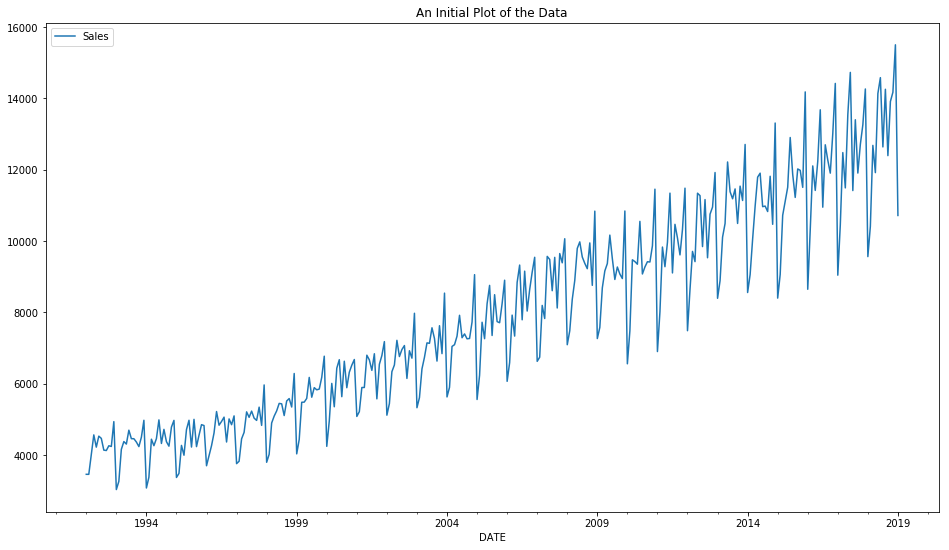

In [46]:
df.plot(title = "An Initial Plot of the Data", figsize = (16,9))

The dataset does exhibit seasonality

## 2. Basic Data Exploration

The main purpose of this section is to reak the series into the **Trend, Seasonality and Residual** components

The `statsmodels` library makes this *very, very easy*.

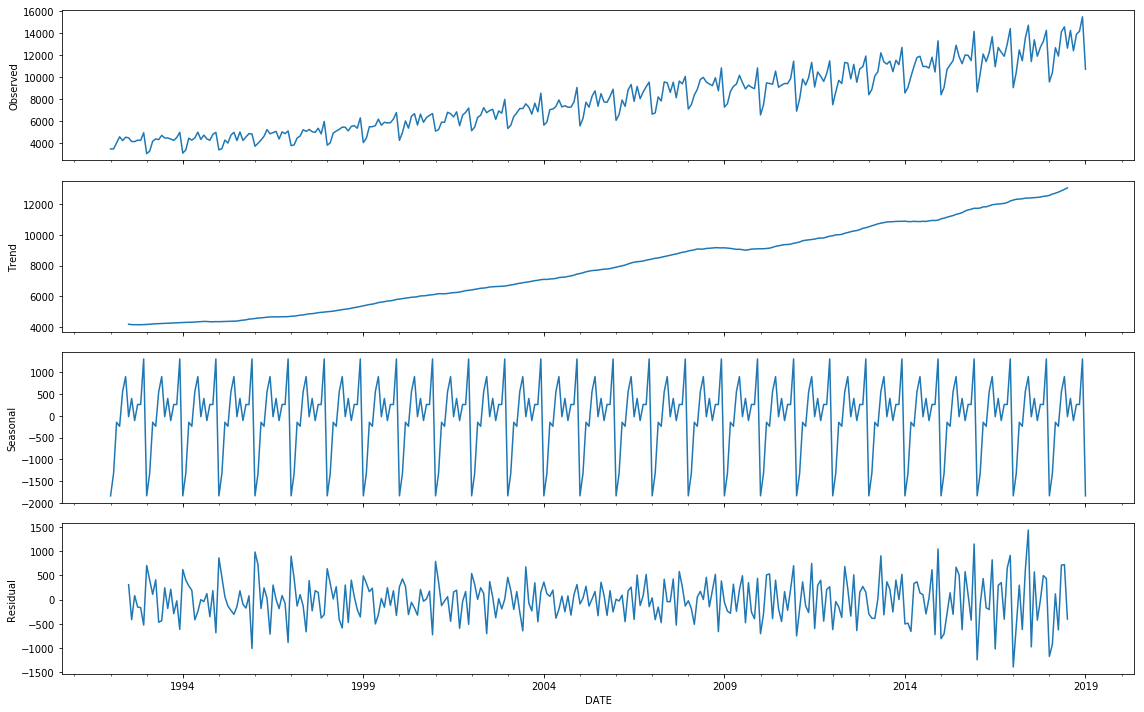

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_components = seasonal_decompose(df['Sales'], model = 'add')

seasonal_components.plot();

As we had suspected there is a definite seasonality in the data.

To verify the frequency (cyclical order) of the seasonality component, I shall be plotting monthly plots

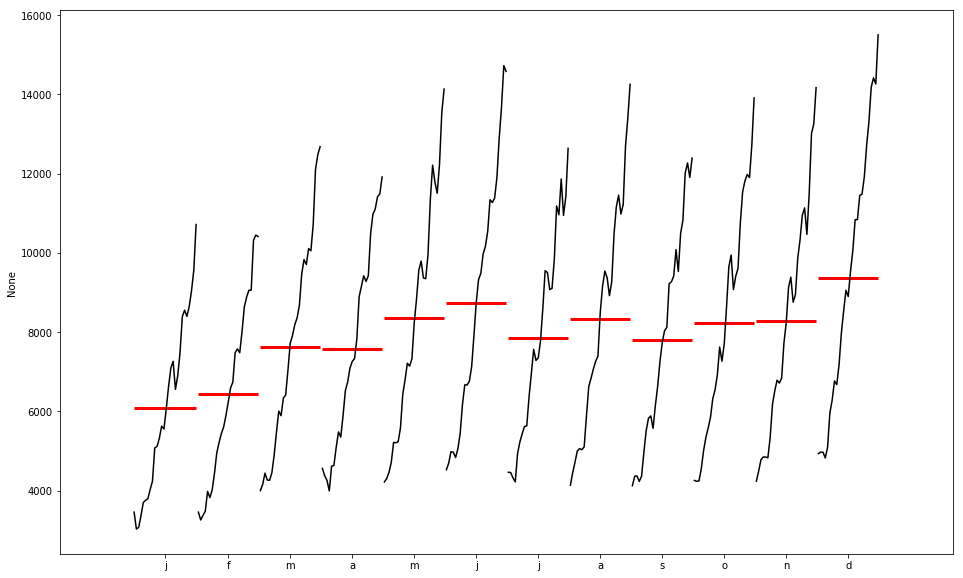

In [48]:
# Plotting a month plot to better understand the seasonality

from statsmodels.graphics.tsaplots import month_plot, quarter_plot

month_plot(df['Sales']);

It is rather interesting to note that alcohol sales peak during the summer months (May - June) and during the holiday season (December)

In [49]:
# Splitting the data into train and test sets

train_12 = df.iloc[:313]
test_12 = df.iloc[313:]

train_24 = df.iloc[:301]
test_24 = df.iloc[301:]


print("size of test_12 set: ",test_12.shape)
print("size of test_24 set: ",test_24.shape)

size of test_12 set:  (12, 1)
size of test_24 set:  (24, 1)


## 3. Naiive Approach: Holt-Winter's Method

Holt-Winter's approach takes in three arguments, `trend` and `seasonality` 'flags' that can be set as *additive* or *multiplicative*. The third argument is `seasonal_periods` which takes a numeric value depending on the seasonality demonstrated by the data.

Setting `trend` and `seasonality` as `add`(additive) and setting the `seasonal_periods` as 12.

In [50]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

triple_exp_model_12 = ExponentialSmoothing(train_12['Sales'],trend = 'add', seasonal = 'add', seasonal_periods = 12)

fitted_model_TES_12 = triple_exp_model_12.fit()

#train_12['TES_model'] = fitted_model_TES_12.fittedvalues

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [51]:
test_predictions_TES_12 = fitted_model_TES_12.forecast(12)

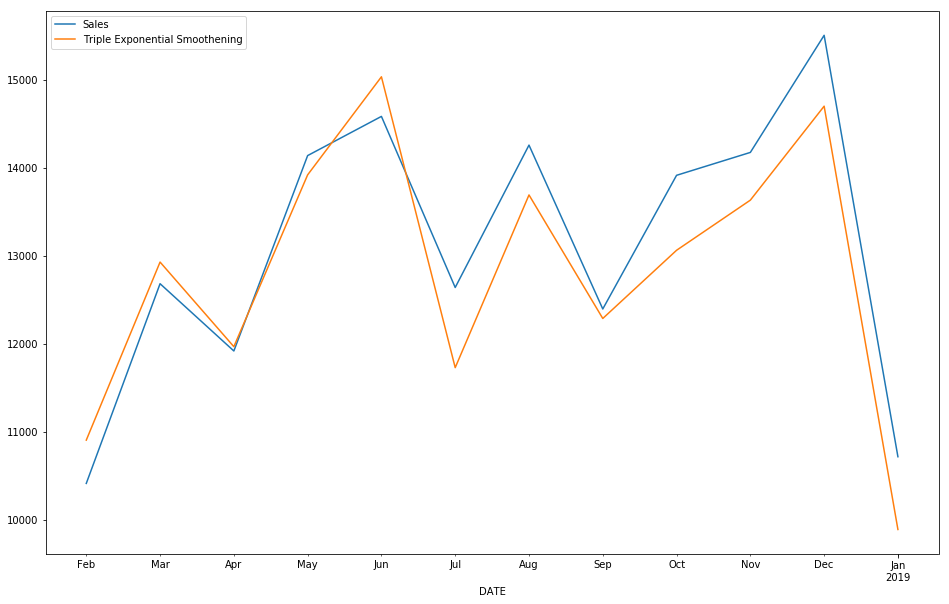

In [52]:
# Plotting Test predictions against the test set
test_12['Sales'].plot(legend = True)
test_predictions_TES_12.plot(legend = True, label = "Triple Exponential Smoothening")

The predictions look **fairly good**. Calculating the MSE (mean squared error) and the RMSE KPI

In [53]:
# Evaluating the RMSE for the Triple Exponential Smoothing Model

from sklearn.metrics import mean_squared_error

mse = mean_squared_error (test_12['Sales'],test_predictions_TES_12)

print(" RMSE for the Triple Exponential Smoothening Model : ", np.sqrt(mse))

 RMSE for the Triple Exponential Smoothening Model :  581.9655553762955


Next up, I'll be attempting an ARIMA based model, which I shall be fitting using `Grid Search`


## 4. ARIMA Based Approach

There are 2 distinct approaches for training an ARIMA based model, while the **classic approach** relies on reading ACF and P-ACF plots *(to ascertain AutoRegressive and Moving Average components)*, diferencing the series *(for making it stationary)* and performing Augmented Dickey Fuller test *(to check for stationarity)* , the **modern approach** uses GridSearch.

In my experience, I have found GridSearch to be more effective in determining the best set of hyperparamers for the ARIMA model.

I'll be following the *modern approach* 

In [54]:
from pmdarima import auto_arima

stepwise_fit = auto_arima(train_12['Sales'],
                          seasonal = True, trace = True, m=12)

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 1, 12); AIC=4335.626, BIC=4365.257, Fit time=2.910 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=4683.931, BIC=4691.338, Fit time=0.143 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=4553.031, BIC=4567.846, Fit time=0.307 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4446.879, BIC=4461.694, Fit time=1.609 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=4346.393, BIC=4372.319, Fit time=2.371 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 1, 1, 12); AIC=4323.486, BIC=4356.820, Fit time=8.968 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 1, 0, 12); AIC=4348.241, BIC=4377.872, Fit time=4.696 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 1, 2, 12); AIC=4272.143, BIC=4309.181, Fit time=9.028 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(2, 1, 2, 12); AIC=4329.116, BIC=4362.450, Fit time=9.737 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 2) seasonal_order=(2, 1, 2, 12); AIC=4286.623, BIC=4327.365, Fit time=10.242 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=4274.026, BIC=4307.360, Fit time=9.556 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(2, 1, 2, 12); AIC=4270.356, BIC=4311.098, Fit time=11.859 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(1, 1, 2, 12); AIC=4286.052, BIC=4323.090, Fit time=11.118 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(2, 1, 1, 12); AIC=4283.742, BIC=4320.779, Fit time=10.701 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 3) seasonal_order=(1, 1, 1, 12); AIC=4284.679, BIC=4318.013, Fit time=4.830 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 3) seasonal_order=(2, 1, 2, 12); AIC=4274.749, BIC=4311.787, Fit time=10.977 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3) seasonal_order=(2, 1, 2, 12); AIC=4273.753, BIC=4318.198, Fit time=13.267 seconds


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 4) seasonal_order=(2, 1, 2, 12); AIC=4276.255, BIC=4320.700, Fit time=13.366 seconds
Total fit time: 135.715 seconds


In [55]:
# The best performing model is..

stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  313
Model:             SARIMAX(2, 1, 3)x(2, 1, 2, 12)   Log Likelihood               -2124.178
Date:                            Tue, 24 Mar 2020   AIC                           4270.356
Time:                                    01:04:43   BIC                           4311.098
Sample:                                         0   HQIC                          4286.661
                                            - 313                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8048      6.251      0.449      0.654      -9.448      15.057
ar.L1         -1.1550      0.009   -133.055      0.000      -1.172      -1.138
ar.L2         -0.9983      0.006   -167.086      0.000      -1.010      -0.987
ma.L1          0.3198      0.064      4.960      0.000       0.193       0.446
ma.L2          0.1010      0.077      1.307      0.191      -0.050       0.252
ma.L3         -0.7846      0.068    -11.564      0.000      -0.918      -0.652
ar.S.L12       0.9154      0.255      3.593      0.000       0.416       1.415
ar.S.L24      -0.6057      0.140     -4.341      0.000      -0.879      -0.332
ma.S.L12      -1.2590      0.260     -4.841      0.000      -1.769      -0.749
ma.S.L24       0.6611      0.223      2.970      0.003       0.225       1.097
sigma2      1.111e+05    1.2e+04      9.258      0.000    8.76e+04    1.35e+05
===================================================================================
Ljung-Box (Q):                       96.28   Jarque-Bera (JB):                21.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.12   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
# Implmenting the recommended model: SARIMAX

from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX


model = SARIMAX(train_12['Sales'],order = (2,1,3), seasonal_order = (2,1,2,12))

result = model.fit()

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [57]:
# Generating Predictions

# Generating predictions
start = len(train_12)
end = len(train_12) + len(test_12) - 1

predictions_SARIMA = result.predict(start = start ,end = end, typ = 'levels')

#IMP: if you choose the default value of "typ" hyperparameter ( 'linear'). you'll get results in terms of differenced data

predictions_SARIMA = predictions_SARIMA.rename('SARIMAX')

In [88]:
predictions_SARIMA

2018-02-01    11042.229945
2018-03-01    12128.944582
2018-04-01    12188.407902
2018-05-01    14152.179261
2018-06-01    14239.980477
2018-07-01    12477.383354
2018-08-01    13673.063833
2018-09-01    12077.334339
2018-10-01    13622.332437
2018-11-01    13329.836938
2018-12-01    14546.665160
2019-01-01    10433.314230
Freq: MS, Name: SARIMAX, dtype: float64

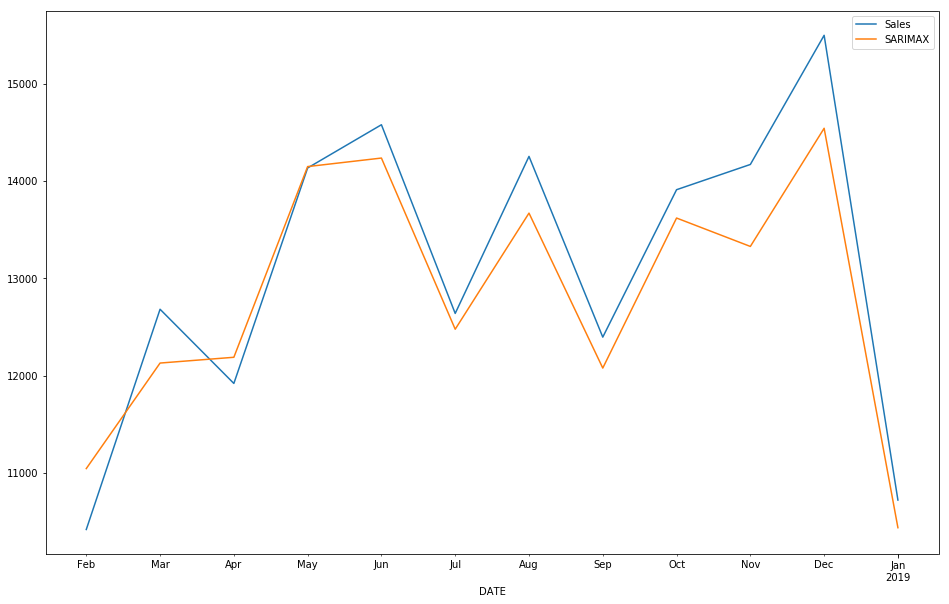

In [58]:
# Plotting test predictions and test data

test_12['Sales'].plot(legend = True)
predictions_SARIMA.plot(legend = True)


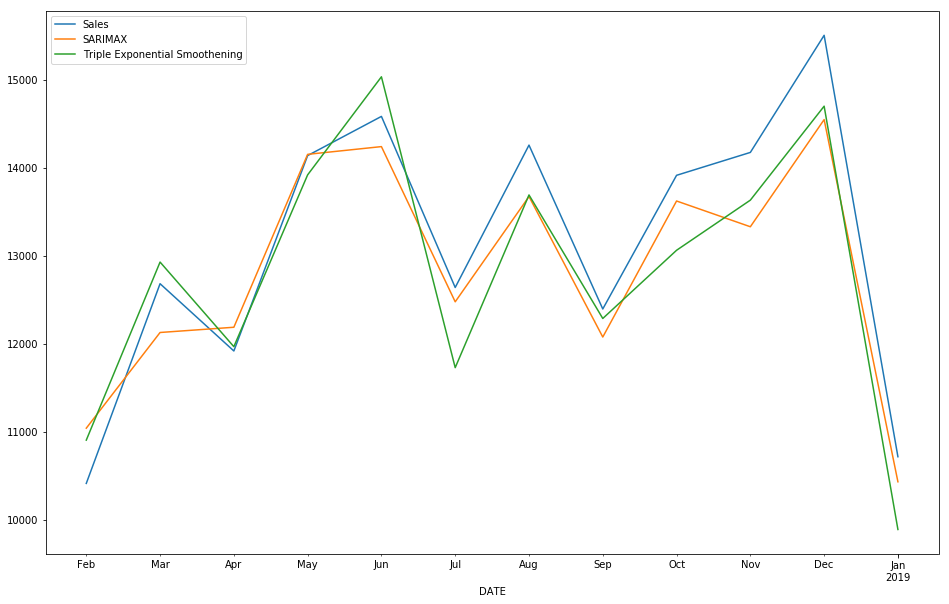

In [59]:
# Plotting all the three predictions together

test_12['Sales'].plot(legend = True)
predictions_SARIMA.plot(legend = True)
test_predictions_TES_12.plot(legend = True, label = "Triple Exponential Smoothening")

The predictons look good. Looking at the graph it is difficult to tell which model performs better.

Calculating the RMSE to understand the performance.

In [60]:
# Evaluating the performance of the model using MSE/RMSE

mse = mean_squared_error(test_12['Sales'], predictions_SARIMA)

#$print("Mean Squared Error (MSE) : ", mse,"\n")
print("RMSE : ", np.sqrt(mse))

RMSE :  512.7564010235911


The ARIMA (SARIMA) based model perfoms better than the Holt-Winters model.

Over to an LSTM based model now.


## 5. Neural Network (LSTM) Based Approach

In [61]:
test_12.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2018-02-01 to 2019-01-01
Freq: MS
Data columns (total 1 columns):
Sales    12 non-null int64
dtypes: int64(1)
memory usage: 192.0 bytes


In [62]:
# Scaling the data

from sklearn.preprocessing import MinMaxScaler

min_max = MinMaxScaler()
min_max.fit(train_12)

train_s = min_max.transform(train_12)
test_s = min_max.transform(test_12)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [63]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

100 neurons in the LSTM layer is a good starting point.
`n_inputs` is something that we can adjust
`n_features` for a time series is always going to be 1

In [64]:
# Step 1: Preprocess the batches

from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12 # a full year's data
n_features = 1

train_generator = TimeseriesGenerator(data = train_s, targets = train_s,
                                length = n_input, batch_size = 1
                               )

In [66]:
import tensorflow as tf
from tensorflow import keras

keras.__version__

'2.2.4-tf'

In [92]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [95]:
# Step 2: define model
model_ts = Sequential()
model_ts.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
#model_ts.add(LSTM(100, activation='relu'))
model_ts.add(Dense(1))


In [80]:
# viewing the model architecture
model_ts.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [81]:
# Step 3: Compiling the model
model_ts.compile(loss= 'mse', optimizer ='adam')

In [82]:
# Step 5: Fitting the model

history = model_ts.fit_generator(train_generator, epochs = 35)

Epoch 1/35
301/301 [==============================] - 4s 12ms/step - loss: 0.0170
Epoch 2/35
301/301 [==============================] - 2s 8ms/step - loss: 0.0085
Epoch 3/35
301/301 [==============================] - 2s 8ms/step - loss: 0.0098
Epoch 4/35
301/301 [==============================] - 2s 8ms/step - loss: 0.0077
Epoch 5/35
301/301 [==============================] - 2s 8ms/step - loss: 0.0061
Epoch 6/35
301/301 [==============================] - 2s 8ms/step - loss: 0.0061
Epoch 7/35
301/301 [==============================] - 2s 8ms/step - loss: 0.0039
Epoch 8/35
301/301 [==============================] - 2s 8ms/step - loss: 0.0032
Epoch 9/35
301/301 [==============================] - 2s 8ms/step - loss: 0.0025
Epoch 10/35
301/301 [==============================] - 2s 8ms/step - loss: 0.0023
Epoch 11/35
301/301 [==============================] - 2s 8ms/step - loss: 0.0020
Epoch 12/35
301/301 [==============================] - 3s 9ms/step - loss: 0.0021
Epoch 13/35
301/301 [===

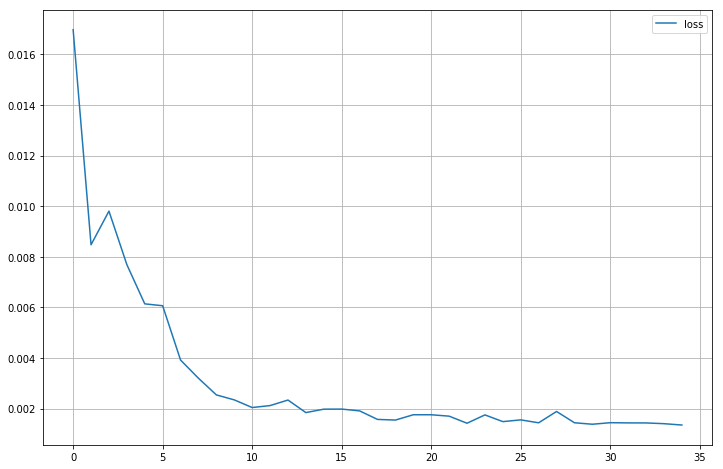

In [83]:
# Step 6: Generate Training Curves
# Use the training curves to decide on the # epoches

import pandas as pd

pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
#save_fig("keras_learning_curves_plot")
plt.show()

In [84]:
# placeholder for predictions
test_predictions = []

# last  n_inpt points from the training set
first_eval_data = train_s[-n_input:]
current_batch = first_eval_data.reshape((1,n_input,n_features)) 

for i in range(len(test_s)):
    current_pred = model_ts.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


In [85]:
test_predictions

[array([0.6780905], dtype=float32),
 array([0.7978262], dtype=float32),
 array([0.7476963], dtype=float32),
 array([0.901845], dtype=float32),
 array([0.9710874], dtype=float32),
 array([0.7321476], dtype=float32),
 array([0.8846445], dtype=float32),
 array([0.7517149], dtype=float32),
 array([0.8314361], dtype=float32),
 array([0.86533046], dtype=float32),
 array([0.9420971], dtype=float32),
 array([0.57279974], dtype=float32)]

In [86]:
true_predictions = min_max.inverse_transform(test_predictions)

In [89]:
test_12['Neural Networks/LSTM Predictions'] = true_predictions

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


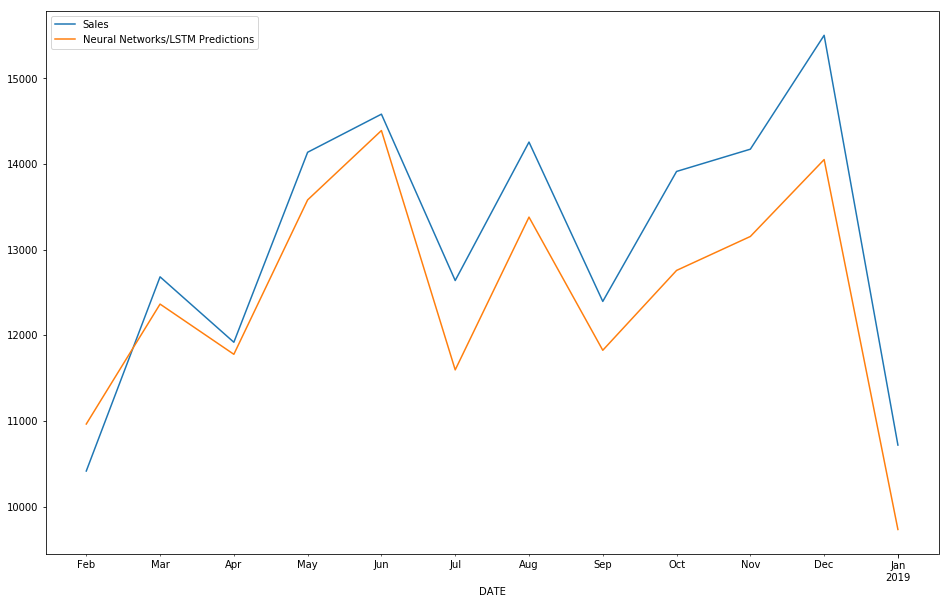

In [90]:
# plotting the results
test_12['Sales'].plot(legend = True)
test_12['Neural Networks/LSTM Predictions'].plot(legend = True)

In [91]:
# Evaluating the performance of the model using MSE/RMSE

mse = mean_squared_error(test_12['Sales'], test_12['Neural Networks/LSTM Predictions'])

#$print("Mean Squared Error (MSE) : ", mse,"\n")
print("RMSE : ", np.sqrt(mse))

RMSE :  836.9503197170928
